# Trabalho Web_Scrapping

## Introdução

O objetivo do projeto é observar as oscilações de preço de imoveis de determinadas regiões. Vamos manipular os dados presentes no site loft.com.br.

Iremos utilizar as seguintes ferramentas:

* Python3
* BeautifulSoup para a extração dos dados
* PySpark para a armazenagem e cálculo

Todo o processo controlado dentro do ambiente do Google Colab.

## Arquitetura

O projeto está esquematizado da seguinte forma:

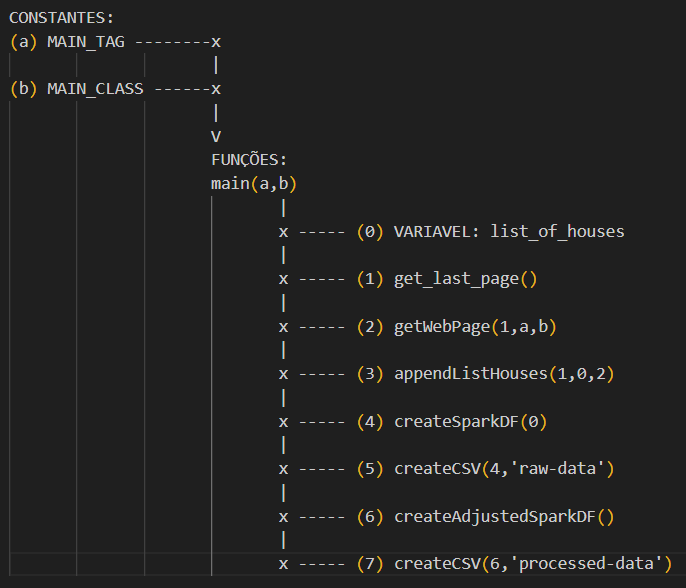

* Nas primeiras linhas temos as variaveis constantes a e b que representam respectivamente os rotulos dos atributos tag e class dos elementos web do qual estamos extraindo os dados. Procuramos isolar essas variaveis a fim de facilitar uma possivel manutenção caso haja mudança nos seus textos.

* Utilizamos as constantes a e b como parametros para a função main(). A main() é a função principal do projeto, é por meio dela que chamamos as diversas outras funções criadas (1, 2, 3, 4, 5, 6, 7). Falaremos mais detalhadamente o que cada uma desempenha dentro do projeto logo abaixo.

* A variavel list_of_houses (0) serve como variavel auxiliar para o armazenamento dos dados, também falaremos mais sobre ela nas proximas sessões.

## Instalação do PySpark e importação de bibliotecas

Antes de executar os scripts dentro desse projeto é importante que o notebook tenha o pacote do PySpark, e como boa pratica vamos compilar a importação de todas as bibliotecas utilizadas antes de executamos o restante do código.

Comando de instalação do PySpark no Google Colab

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=62e052b7061a8ea7fd15d6169fc71e2bb797256b596ccd44eff71f18d35d00ab
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


Script Python que importa as bibliotecas.

* O primeiro bloco importa os recursos utilizados para a extração dos dados da internet.
* O segundo bloco importa os recursos utilizados para a armazenagem, manipulação e cálculo dos dados extraidos.
* O terceiro bloco importa recursos auxiliares importantes para manipulação de arquivos dentro do Google Colab.

In [2]:
from bs4 import BeautifulSoup
import requests

from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as func
import pyspark.sql.types as t

import os
import glob
import shutil

## Função get_last_page()

Tem como finalidade retornar o número que representa a ultima página de imóveis de uma determinada região.

É importante explicar a forma como estamos pegando os dados dentro do site loft.com.br. Se olharmos a variavel url temos o seguinte padrão:

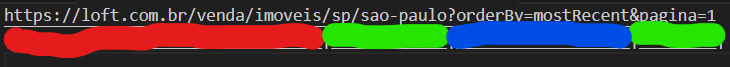

A url busca os imoveis dos mais recentes aos mais antigos do estado de São Paulo da página 1 de seleção, o trecho em vermelho é a parte do endereço que não sofre variações, ja o trecho em verde é suscetível de mudanças, podemos trazer outros imoveis de outros estados para a análise (rj/rio-de-janeiro) por exemplo ou trazer outro número de paginação. O trecho em azul também pode ser alterado, podemos ordenar os dados dos mais antigos aos mais novos ou do imovel mais caro para o mais barato e vice e versa, para o proposito desse projeto resolvemos não utilizar essa ordenação visto que vamos trazer todos os dados independente de como estão dispostos.

Para que fique claro, neste exercicio vamos apenas trabalhar com os dados disponíveis no estado de São Paulo, o que vai variar será a paginação apenas.

Portanto, afim de pegar todos os dados desse grupo, precisamos saber a ultima página de seleção, por essa razão que criamos a função.

Segue abaixo as ações dessa função:

1. Guarda o endereço web
2. Faz o parser do conteúdo da página
3. Localiza a parte do conteúdo direcionada ao ultimo número de paginação e realiza a conversão para inteiro


In [3]:
def get_last_page():
  url = f"https://loft.com.br/venda/imoveis/sp/sao-paulo?orderBy=mostRecent&pagina=1"
  page = requests.get(url)
  soup = BeautifulSoup(page.content, "html.parser")

  num = int(soup.find_all('ul',class_ = 'MuiPagination-ul')[0]. \
            find_all('li')[6].text)

  return num


## Função getWebPage()

A função retorna um trecho do conteúdo de uma determinada página, recebendo a numeração da página, a tag de identificação e a classe de identificação do conjunto de elementos que queremos localizar.

Conforme mencionado na sessão de introdução, antes de executarmos a extração, nós declaramos duas variáveis constantes main_tag e main_class. Essas duas informações são importantes para delimitar qual o conjuntos de elementos dentro do site que vamos extrair os dados.

A ideia é pegar apenas o que é necessário para o nosso objetivo, além disso teremos um ganho de computação pois essa função é executada multiplas vezes conforme falaremos mais adiante.

Segue abaixo as ações dessa função:
1. Guarda o endereço web com paginação determinada
2. Faz o parser de parte do conteúdo baseado no valor das variaveis t (main_tag) e c (main_classe)
3. Retorna essa parte em formato texto

In [4]:
def getWebPage(num,t,c):
  url = f"https://loft.com.br/venda/imoveis/sp/sao-paulo?orderBy=mostRecent&pagina={num}"
  page = requests.get(url)
  soup = BeautifulSoup(page.content, "html.parser")
  webPage = soup.find_all(t,class_ = c)

  return webPage

## Função appendListHouses()

Mencionamos a variável `list_of_houses`, ela tem como utilidade guarda os dados que estamos extraindo no site enquanto o script ainda está sendo processado. A sua tipagem está classificada como uma lista de dicionários.

O que a função appendListHouse() faz é inserir dados do tipo dicionário para dentro da variável list_of_houses.

A cada pedaço de conteudo extraido de uma página, a função pega trechos de informações referentes ao imóvel (valores de preço, endereço e bairro por exemplo) e transforma-os em um dicionário pronto para inserção.

Neste execicio basta entender que o dicionario são dados (ou caracteristicas) direcionados à um determinado imóvel.

O processo de inserção pode acontecer multiplas vezes pois um pedaço de conteúdo pode conter dados de mais de um imóvel.  

É importante mencionar que essa é uma função que não tem retorno (tipo void), seu processamento é encima dos parametros recebidos:
* num -> Número da paginação do site do qual os dados foram extraído, incluímos ele como um meta dado dentro do dicionário. No resultado final ele não é incluido, contudo ele foi útil nos processos de depuração e pode ser importante ter essa informação em caso de manutenção.
* list_of_houses -> Como explicado acima, ela é uma variavel importante no processo de armazenagem e será chamada várias vezes.
* contents -> O conteudo onde está os dados dos imóveis.

Segue abaixo as ações dessa função:
1. Pega parte do conteudo de uma pagina. Dentro desse conteudo há um conjunto de elementos
2. Para cada elemento são extraidos informações referentes a um determinado imóvel que são transformados em dicionário
3. O dicionário criado é inserido dentro da lista list_of_houses
4. As etapas 2 e 3 são repetidas até que todos os elementos do conjunto sejam extraidos.

In [5]:
def appendListHouses(num,list_of_houses,contents):

  for c in contents:
    address = c.find_all('h2')[0].text.split(', ')[0]
    neighborhood = c.find_all('h2')[0].text.split(', ')[1]
    type_house = c.find_all('span')[0].text
    try:
      price = float(c.find_all('span')[1].text.replace('.','').replace('R$ ',''))
    except ValueError:
      price = float(type_house.replace('.','').replace('R$ ',''))
      type_house = 'indisponível'

    list_of_houses.append({
        'page_num':num,
        'address':address,
        'neighborhood':neighborhood,
        'type_house':type_house,
        'price':price

      })




## Função createSparkDF()

Por meio dos métodos do PySpark a função transforma os valores contidos dentro da variavel list_of_houses em uma variavel de dados do tipo dataframe.

A transformação para dataframe é importante para o processo de armazenagem para o formato csv como também para o cálculo da oscilação.

Segue abaixo as ações dessa função:
1. Cria uma sessão de conexão ao server local do apache spark
2. Cria uma variavel do tipo dataframe conforme list_of_houses é interada, ou seja, cada dicionario é transformado em uma linha de registro, e seus dados viram colunas
3. Retorna o dataframe criado


In [6]:
def createSparkDF(list_of_houses):
  appName = "Trabalho Web_Scrapping Impacta - loft to CSV"
  master = "local"

  spark = SparkSession.builder \
      .appName(appName) \
      .master(master) \
      .getOrCreate()

  df = spark.createDataFrame([Row(**i) for i in list_of_houses])
  return df

## Função createCSV()

A função cria um arquivo em csv a partir do dataframe criado. Recebe como parametros o dataframe que será transformado em .csv e o nome da pasta onde será alocado o arquivo criado.

Há dois momentos onde essa função será utilizada: Quando criamos o arquivo bruto apenas com os dados tirados no site e quando salvamos o arquivo final com os calculos de oscilação feitos.

Segue abaixo as ações dessa função:
1. Antes de criarmos o arquivo verificamos se o mesmo já não foi criado anteriormente. Caso ele exista, a função a remove
2. Salvamos o dataframe no arquivo especificado

In [7]:

def createCSV(df,destiny):

  if os.path.isfile(f'/content/{destiny}/_SUCCESS'):
    os.remove(f'/content/{destiny}/_SUCCESS')

    for filename in glob.glob(f'/content/{destiny}/*.csv'):
      os.remove(filename)

    shutil.rmtree(f'/content/{destiny}')

  df.write.csv(destiny, header = 'true')

  for filename in glob.glob(f'/content/{destiny}/*.csv'):
      os.rename(filename, f'/content/{destiny}/result.csv')



## Função createAdjustedSparkDF()

Esta função realiza os cálculos necessarios para encontrar a oscilação de preços, agrupados por bairro.

Neste exercicio a oscilação corresponte 3 valores:
* O valor minimo
* O valor maximo
* O valor médio

A diferença entre o valor minimo com o maximo é o intervalo de preços de imoveis, quanto maior o intervalo, maior é a sua oscilação. Se formos incluir o valor medio saberemos qual a tendência da amostragem, se o valor da média for mais proximo do maximo, significa que há poucos imoveis abaixo do preço na região e vice versa.

Por exemplo suponha o bairro X, dentro dele há imoveis que os preços variam entre 600.000 a 1.000.000 e a média de preço da amostra é de 850.000. O que podemos dizer é que os preços naquela região tem uma alta variação mas eles tem uma tendencia de estarem com o preço mais proximo do máximo.

Segue abaixo as ações dessa função:
1. Cria uma sessão no server local no PySpark
2. Lê os dados brutos que foram salvos em csv
3. O script cria 3 dataframes agrupados por bairros, cada um contendo os valores maximos, minimos e médios respectivamente, todo o processo de calculo feito por meio das funções do PySpark
4. Em sequida é realizado a junção desses 3 dataframes em um só.
5. Ordenamos o dataframe final para conter apenas os dados bairro, preço máximo, preço minimo e preço médio
6. Por a função retorna o dataframe ajustado

In [18]:
def createAdjustedSparkDF():

  appName = "Trabalho Web_Scrapping Impacta - read CSV"
  master = "local"

  spark = SparkSession.builder \
        .appName(appName) \
        .master(master) \
        .getOrCreate()

  raw = spark.read.csv('/content/raw-data/result.csv', \
                            header=True, inferSchema=True)

  df_max = raw.groupBy('neighborhood').max("price")
  df_max =  df_max.withColumn("max(price)",func.round(df_max["max(price)"], 2)). \
                      withColumnRenamed("max(price)","max_price")
  df_max =  df_max.withColumn('max_price', \
                            df_max.max_price.cast(t.DecimalType(18, 2)))

  df_min = raw.groupBy('neighborhood').min("price")
  df_min = df_min.withColumn("min(price)",func.round(df_min["min(price)"], 2)). \
                      withColumnRenamed("min(price)","min_price")
  df_min = df_min.withColumn('min_price', \
                            df_min.min_price.cast(t.DecimalType(18, 2)))

  df_avg = raw.groupBy('neighborhood').avg("price")
  df_avg = df_avg.withColumn("avg(price)",func.round(df_avg["avg(price)"], 2)). \
                      withColumnRenamed("avg(price)","avg_price")
  df_avg = df_avg.withColumn('avg_price', \
                            df_avg.avg_price.cast(t.DecimalType(18, 2)))

  result = df_max. \
      join(df_min, df_max.neighborhood == df_min.neighborhood, "inner"). \
      drop(df_max.neighborhood)

  result = result. \
      join(df_avg, result.neighborhood == df_avg.neighborhood, "inner"). \
      drop(result.neighborhood)

  result = result.select('neighborhood','max_price','avg_price','min_price')

  return result

## Função main_script()

Esta é a função principal do projeto, é ela que executa todas as funções mencionadas acima.

Segue abaixo as ações dessa função:

1. Recebe as strings das variaveis constantes MAIN_TAG e MAIN_CLASS
2. Executa a função get_last_page para saber o ultimo indice de paginação dos dados
3. A variavel list_of_houses é instanciada
4. A função getWebPage é chamada para extrair o conteudo da página requisitado
5. Executa appendListHouses que pega os dados dentro do resultado de getWebPage para inclui-lo dentro de list_of_house
6. Os passos 4 e 5 são repetidos até que todas as paginações sejam extraidas
7. Ocorre a transformação da variavel list_of_houses em dataframe (variavel df) por meio da função createSparkDF
8. Chamamos a função createCSV para salvar o dataframe criado (dado bruto) no formato csv   
9. Em seguida executa a função createAdjustedSparkDF que cria um novo dataframe (dados processados) baseado nos dados ja salvos em csv, este por sua vez será o resultado final do nosso execicio
10. Ocorre uma nova chamda na função createCSV onde os dados ajustados são salvos em csv

In [9]:
def main_script(t,c):
  num = get_last_page()

  list_of_houses = []

  for i in range(num):
      contents = getWebPage(i+1,t,c)
      appendListHouses(i+1,list_of_houses,contents)


  df = createSparkDF(list_of_houses)

  createCSV(df,'raw-data')

  adjusted_df = createAdjustedSparkDF()

  createCSV(adjusted_df,'processed-data')


## Script de execução

Por fim temos o nosso script que inicia o processamento de todos os demais.

Podemos observar que é por meio dele que declaramos nossas variaveis constantes sujeitas a mudanças e chamamos a função principal do nosso projeto.

Uma vez compilado todos os scripts acima, esse bloco irá trazer como resultado os arquivos csv dos dados brutos, aqueles que foram extraidos diretamente do site e dos dados processados contendo o resultado final.

In [19]:
MAIN_TAG = "div"
MAIN_CLASS = "jss287"

main_script(MAIN_TAG,MAIN_CLASS)